<a href="https://colab.research.google.com/github/sujatasaini/keras-video-classification/blob/master/keras_video_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [ ]:
#HMDB51 - About 2GB for a total of 7,000 clips distributed in 51 action classes.
#https://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/#Downloads
!wget -O hmdb51_org.rar http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar

--2020-10-12 13:32:58--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar [following]
--2020-10-12 13:32:59--  https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2124008126 (2.0G)
Saving to: ‘hmdb51_org.rar’

hmdb51_org.rar      100%[===================>]   1.98G  15.8MB/s    in 2m 12s  

2020-10-12 13:35:11 (15.3 MB/s) - ‘hmdb51_org.rar’ saved [2124008126/2124008126]



In [ ]:
!unrar e -r hmdb51_org.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from hmdb51_org.rar

Extracting  shoot_gun.rar                                                  0%  1%  OK 
Extracting  sit.rar                                                        1%  2%  3%  OK 
Extracting  situp.rar                                                      3%  4%  OK 
Extracting  smile.rar                                                      4%  5%  OK 
Extracting  smoke.rar                                                      5%  6%  7%  OK 
Extracting  somersault.rar                                                 7%  8%  9%  OK 
Extracting  stand.rar                                                      9% 10% 11%  OK 
Extracting  swing_baseball.rar                                            11% 12% 13%  OK 
Extracting  sword.rar                                      

#Choose the classes to train on

In [ ]:
classes_to_train = ["hug","sword","laugh","dive"]

In [ ]:
import os
#extract the classes
for class_name in classes_to_train:
    os.system(f"unrar x -r {class_name}.rar")
    print(f"Extracted class directory {class_name}")

Extracted class directory hug
Extracted class directory sword
Extracted class directory laugh
Extracted class directory dive


# Prepare dataset for model

### Install video data generator

In [ ]:
!pip install keras-video-generators


  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp36-none-any.whl size=12883 sha256=f1b251114a12f76d321f69a318c7436b3849d18d4f78c0575a9aa0cf1b7b93fe
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [ ]:
import keras
from keras_video import VideoFrameGenerator

classes = classes_to_train
classes.sort()

# some global params
SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 5
BATCHSIZE = 8
# pattern to get videos and classes
glob_pattern='{classname}/*.avi'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.33, 
    shuffle=True,
    batch_size=BATCHSIZE,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

valid = train.get_validation_generator()

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class dive, validation count: 41, train count: 86
class hug, validation count: 38, train count: 80
class laugh, validation count: 42, train count: 86
class sword, validation count: 41, train count: 86
Total data: 4 classes for 338 files for train
Total data: 4 classes for 162 files for validation


# Show the data

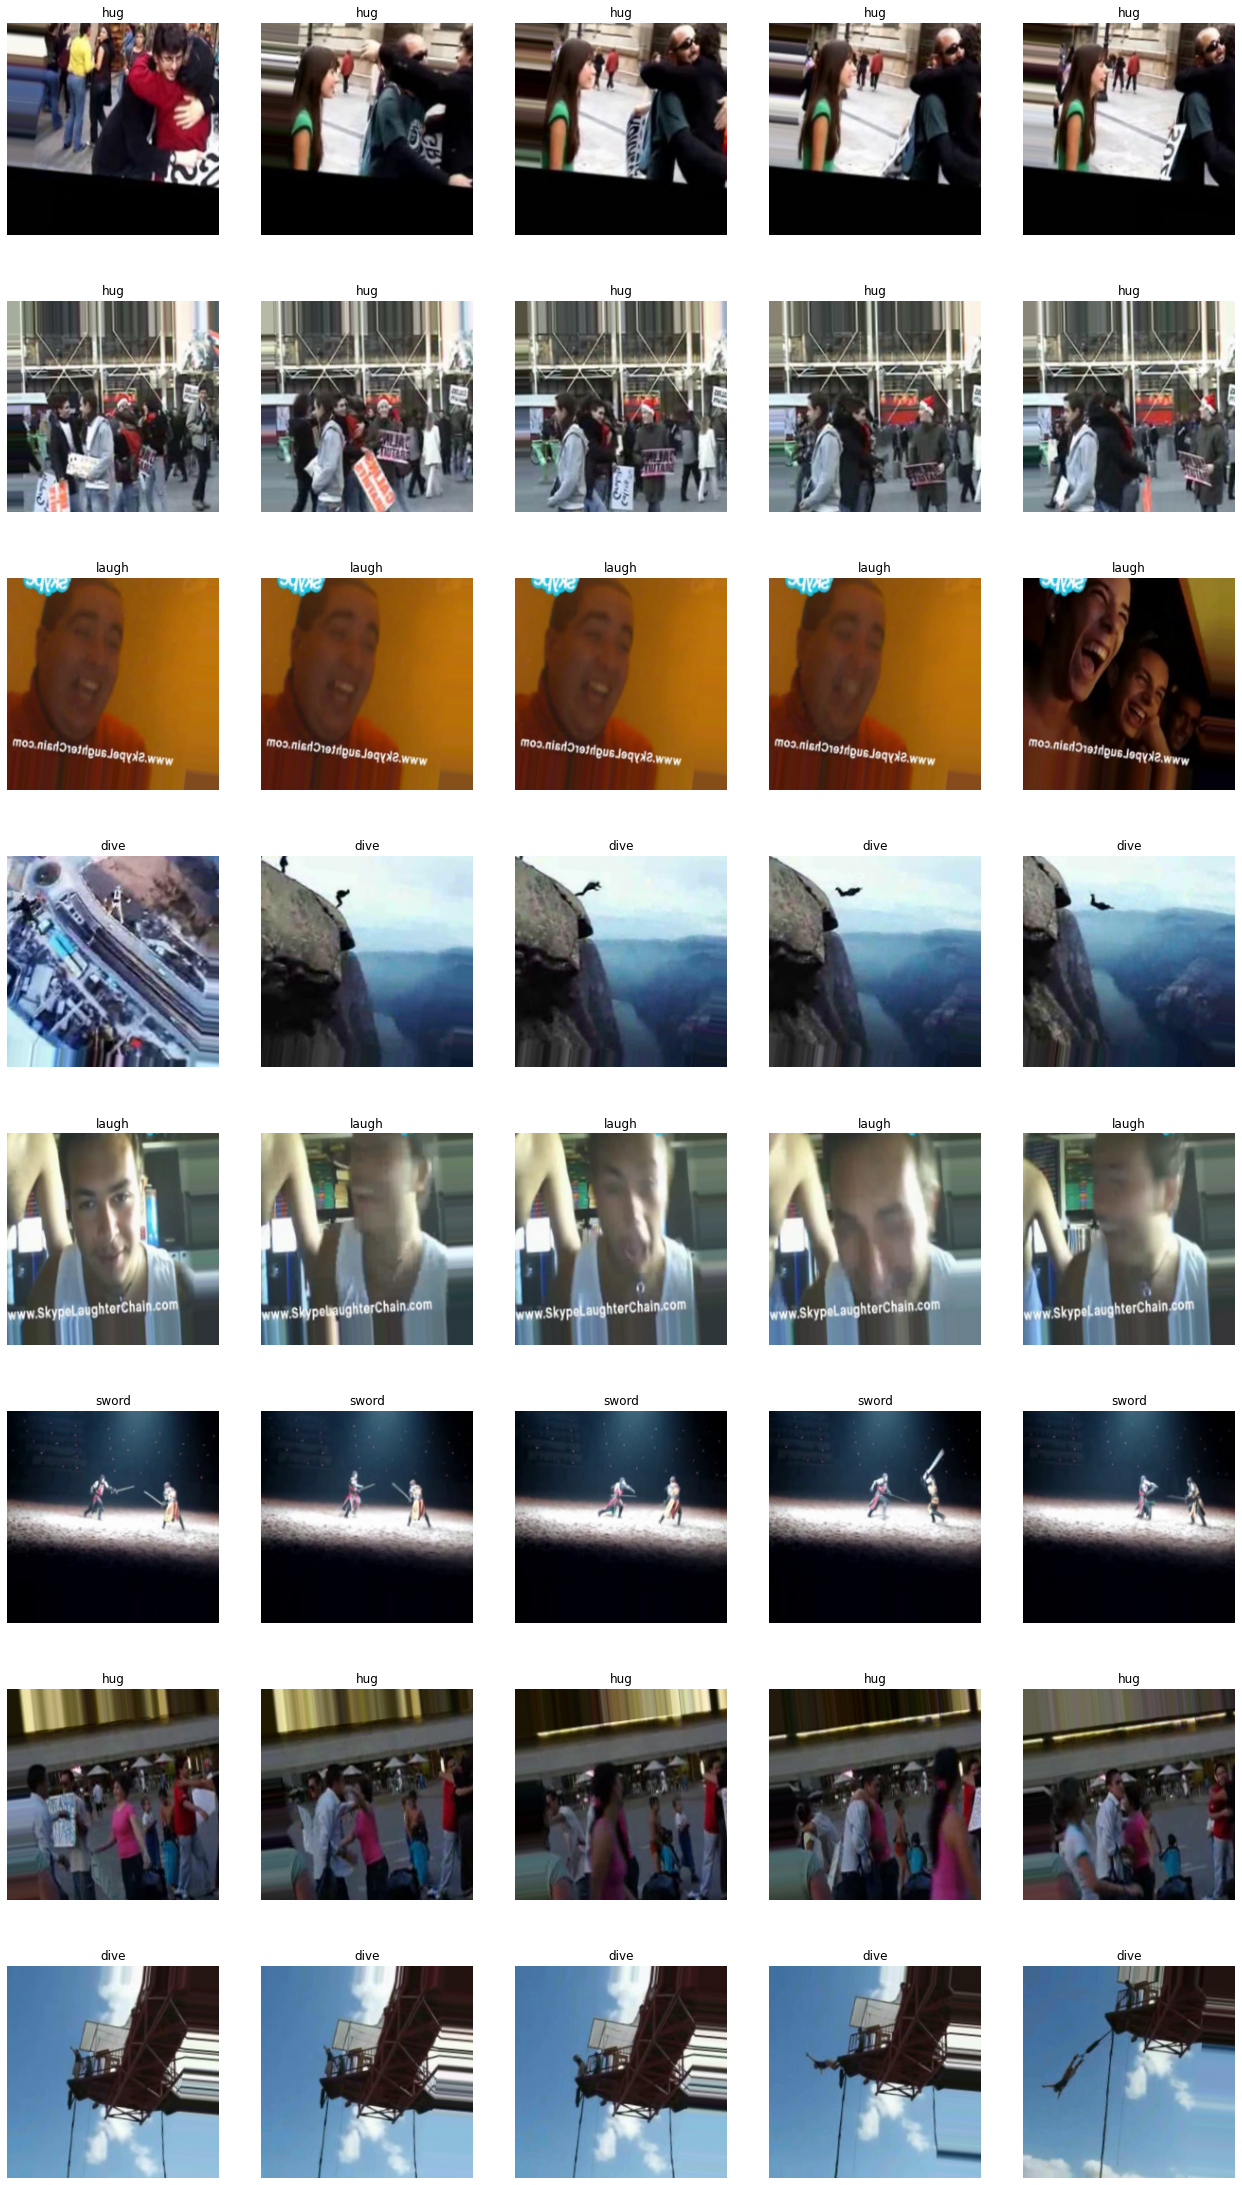

In [ ]:
import keras_video.utils
keras_video.utils.show_sample(train)

# Build your first model

## Define a model to process a single frame (e.g vgg16)

In [ ]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(224, 224, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

## Define the wrapper model, the "action_model" model

In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape=(5, 224, 224, 3), nbout=3):
    # Create our convnet with (224, 224, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 224, 224, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

## Let’s create the model

In [ ]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 224, 224, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

# Train the model
*This can take a while*

In [ ]:
if not os.path.isdir("chkp"):
   os.mkdir("chkp")

EPOCHS=10

callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 1.4463 - categorical_accuracy: 0.2530
Epoch 00001: saving model to chkp/weights.01-1.39.hdf5
42/42 [==============================] - 85s 2s/step - loss: 1.4463 - categorical_accuracy: 0.2530 - val_loss: 1.3910 - val_categorical_accuracy: 0.2438
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 1.4257 - categorical_accuracy: 0.2530
Epoch 00002: saving model to chkp/weights.02-1.39.hdf5
42/42 [==============================] - 51s 1s/step - loss: 1.4257 - categorical_accuracy: 0.2530 - val_loss: 1.3855 - val_categorical_accuracy: 0.2562
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 1.4297 - categorical_accuracy: 0.2768
Epoch 00003: saving model to chkp/weights.03-1.40.hdf5
42/42 [==============================] - 51s 1s/step - loss: 1.4297 - categorical_accuracy: 0.2768 - val_loss: 1.3959 - val_categorical

# Build a model with pretrained CNN model, vgg16

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Nadam

#set frame model input
cnn_base = VGG16(input_shape=(224,224,3),weights="imagenet",
                 include_top=False)
cnn_out = GlobalAveragePooling2D()(cnn_base.output)
cnn = Model(cnn_base.input,cnn_out)
#lock frame cnn weights from retraining
cnn.trainable = False
#set video input
video = Input(shape=(5,224,224,3))
encoded_frames = TimeDistributed(cnn)(video)
encoded_sequence = LSTM(256)(encoded_frames)
hidden_layer = Dense(1024, activation="relu")(encoded_sequence)
outputs = Dense(len(classes_to_train), activation="softmax")(hidden_layer)
model_with_vgg16 = Model([video], outputs)

optimizer = Nadam(lr=0.002,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)
model_with_vgg16.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["categorical_accuracy"]) 

58892288/58889256 [==============================] - 1s 0us/step


# Train the model
*This should be faster than earlier*

In [ ]:
if not os.path.isdir("chkpvgg16"):
   os.mkdir("chkpvgg16")

EPOCHS=50

callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkpvgg16/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
model_with_vgg16.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 1.2647 - categorical_accuracy: 0.4018
Epoch 00001: saving model to chkpvgg16/weights.01-0.93.hdf5
42/42 [==============================] - 30s 725ms/step - loss: 1.2647 - categorical_accuracy: 0.4018 - val_loss: 0.9310 - val_categorical_accuracy: 0.5375
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 0.8917 - categorical_accuracy: 0.5863
Epoch 00002: saving model to chkpvgg16/weights.02-0.94.hdf5
42/42 [==============================] - 30s 714ms/step - loss: 0.8917 - categorical_accuracy: 0.5863 - val_loss: 0.9353 - val_categorical_accuracy: 0.5500
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 0.7781 - categorical_accuracy: 0.6667
Epoch 00003: saving model to chkpvgg16/weights.03-0.79.hdf5
42/42 [==============================] - 30s 715ms/step - loss: 0.7781 - categorical_accuracy: 0.6667 - val_loss: 0.7921 - val_categorical_accuracy: 0.6187
Epoch 4/50
42/42 [================

# Now lets try it with pretrained weights using self supervision

## Prepare the dataset accordingly - TBD

In [ ]:
TBD

## Build model - TBD

In [ ]:
TBD
